In [1]:
import detectron2
import numpy as np
import os
import shutil
import torch
import cv2
import random
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from matplotlib import pyplot as plt
import glob

%matplotlib inline
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
os.makedirs("images", exist_ok=True)
if  len(os.listdir("images")) == 0:
    !curl -L "https://universe.roboflow.com/ds/4tQNhO3ScX?key=vzphVaMKf7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip;
    shutil.move("test", "images/test")
    shutil.move("train", "images/train")
    shutil.move("valid", "images/valid")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device.type)
!nvcc --version

Using PyTorch version: 2.6.0  Device: cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [4]:
register_coco_instances("trashnet_train", {}, "images/train/_annotations.coco.json", "images/train")
register_coco_instances("trashnet_test", {}, "images/test/_annotations.coco.json", "images/test")
register_coco_instances("trashnet_valid", {}, "images/valid/_annotations.coco.json", "images/valid")
labels =["trash","cardboard","glass","metal","paper", "plastic"]

In [5]:
train_meta = MetadataCatalog.get("trashnet_train")
train_dict = DatasetCatalog.get("trashnet_train")

WARNING [05/02 16:09:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/02 16:09:44 d2.data.datasets.coco]: Loaded 1757 images in COCO format from images/train/_annotations.coco.json


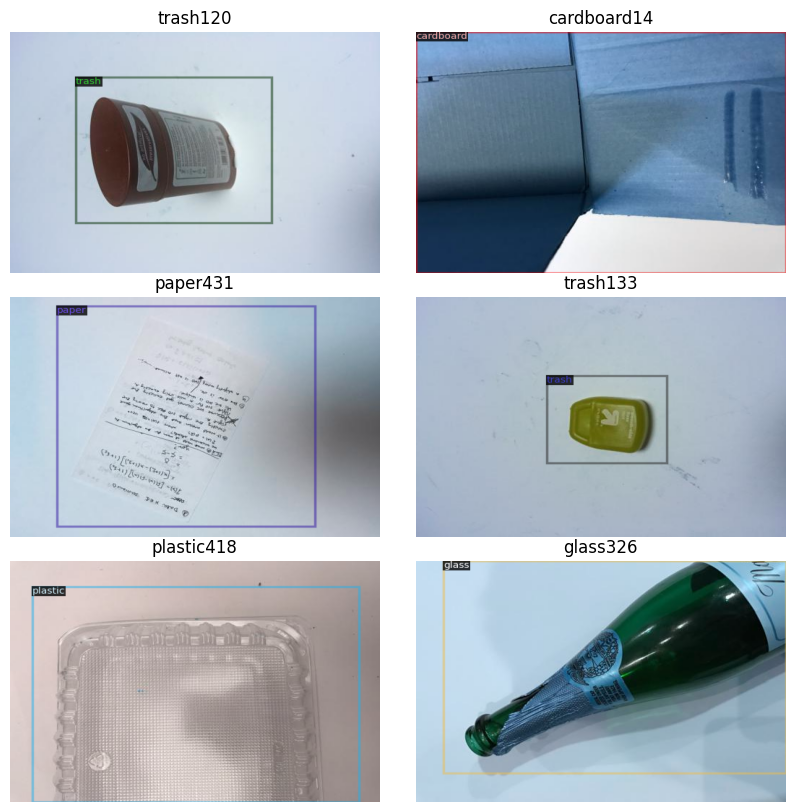

In [6]:
objects = random.sample(train_dict, 6)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
i = 0
for obj in objects:
    img = cv2.imread(obj["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_meta)
    vis = visualizer.draw_dataset_dict(obj)

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(vis.get_image()[:, :, ::-1], aspect="auto")
    axes[row, col].set_title(obj["file_name"].split("_jpg")[0].split("/")[-1])
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [7]:
class COCOTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

train_meta.get("thing_classes", None)

['idk', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trashnet_train",)
cfg.DATASETS.VALIDATION = ("trashnet_valid",)
cfg.DATASETS.TEST = ("trashnet_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 2500
cfg.MODEL.DEVICE = device.type
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)

In [ ]:
#ONLY if you want training!
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = COCOTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("trashnet_test", )
predictor = DefaultPredictor(cfg)

[05/02 16:15:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [05/02 16:15:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/02 16:15:08 d2.data.datasets.coco]: Loaded 264 images in COCO format from images/test/_annotations.coco.json


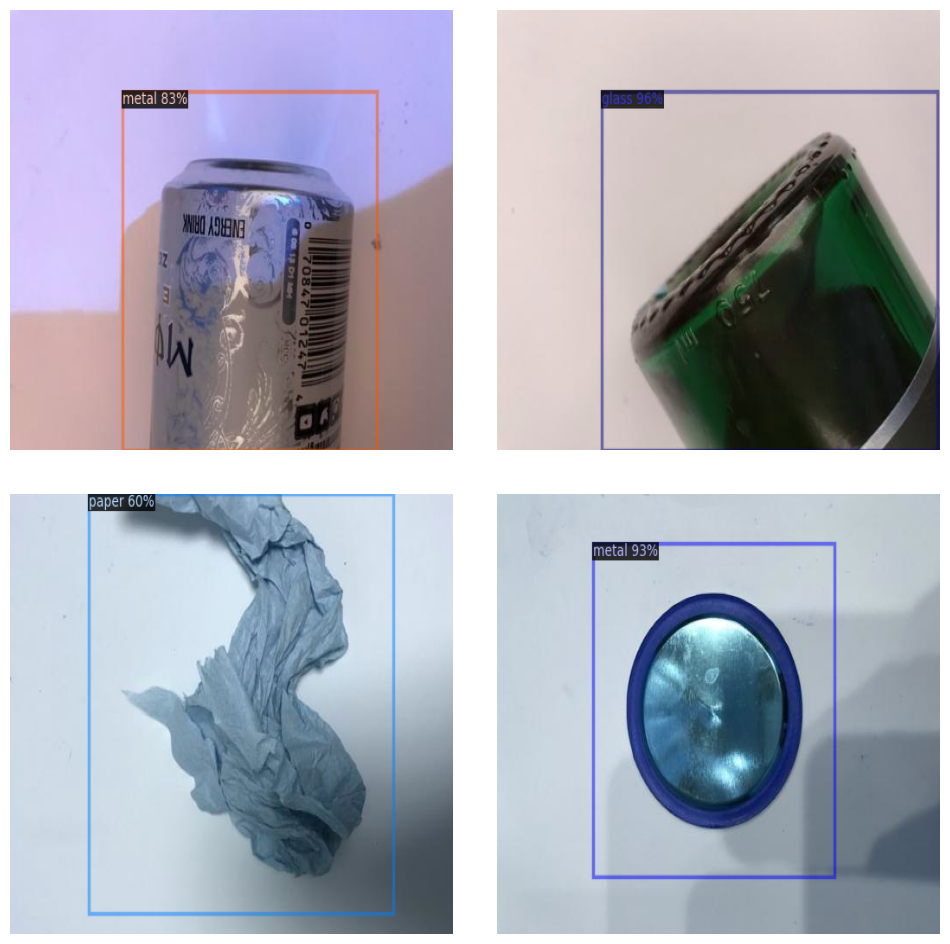

In [15]:
test_metadata = MetadataCatalog.get("trashnet_test")
test_dict = DatasetCatalog.get("trashnet_test")

objects = random.sample(test_dict, 4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
i = 0

for obj in objects:
    img = cv2.imread(obj["file_name"])
    output = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(output["instances"].to("cpu"))

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(out.get_image()[:,:,::-1], aspect="auto")
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [12]:
%load_ext tensorboard
%tensorboard --logdir=output